# Using a Deep Neural Network with Grid Search to Pedict NBA Contracts

### Import Libraries

In [50]:
# Use scikit-learn to grid search the activation function
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt

### Read Databases

In [2]:
# Read historical Data from 1989-2018 Seasons
df = pd.read_csv('historical_data2.csv')


#Read 2018-10 Database
df_2018 = pd.read_csv('2018-19 Data2.csv')

### Define stats that will serve as features. Target variale is percent_of_cap

In [3]:
features = ['years_pro', 'age', 'g',
       'gs', 'mp', 'fgm', 'fga', 'fg_perc', '3pm', '3pa', '3p_perc', '2pm',
       '2pa', '2p_perc', 'efg', 'ftm', 'fta', 'ft_perc', 'orb', 'drb', 'trb',
       'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'per', 'ts', '3par', 'ftr',
       'orb_perc', 'drb_perc', 'trb_perc', 'ast_perc', 'stl_perc', 'blk_perc',
       'tov_perv', 'usg_perc', 'ows', 'dws', 'ws', 'ws_per_48', 'obpm', 'dbpm',
       'bpm', 'vorp', 'percent_of_cap']

### Split database into training and testing sets with 75%/25% split.

In [4]:
# Test train split
X = df[features].drop('percent_of_cap', axis = 1).values
y = df['percent_of_cap'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [5]:
# Only fit scaler to training data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Build variable deep network to use with CVSearch 

In [9]:
def dnn_model(neurons = 1, h_layers = 0, activation = 'relu', loss = 'mse' ):
    model = Sequential()
    
    model.add(Dense(neurons, input_dim = X_train.shape[1],  activation = activation))
    
    #Add hidden layers
    for i in range(1, h_layers + 1):
        
        model.add(Dense(neurons,  activation = activation))
            
    model.add(Dense(1, activation = activation))              
    
    model.compile(loss = loss, optimizer = 'adam', metrics=['mse'] ) 
    return model

In [7]:
# Define early stop parameter
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor= 'loss', mode = 'min',
                           verbose = 0, patience = 25)

In [12]:
estimator = KerasRegressor(build_fn=dnn_model, epochs=250, batch_size=25, verbose=0)

# define the grid search parameters
activation = ['relu', 'sigmoid']
neurons = [10, 20, 30, 40] 
h_layers = [1,2]
loss = ['mse', 'mae', 'msle']
param_grid = dict(activation=activation, neurons=neurons, h_layers=h_layers, loss = loss)

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train, y_train, validation_data = (X_test, y_test), callbacks = [early_stop])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.001935 using {'activation': 'sigmoid', 'h_layers': 2, 'loss': 'msle', 'neurons': 20}
-0.006036 (0.004537) with: {'activation': 'relu', 'h_layers': 1, 'loss': 'mse', 'neurons': 10}
-0.006097 (0.004494) with: {'activation': 'relu', 'h_layers': 1, 'loss': 'mse', 'neurons': 20}
-0.012436 (0.000171) with: {'activation': 'relu', 'h_layers': 1, 'loss': 'mse', 'neurons': 30}
-0.006171 (0.004282) with: {'activation': 'relu', 'h_layers': 1, 'loss': 'mse', 'neurons': 40}
-0.034809 (0.000913) with: {'activation': 'relu', 'h_layers': 1, 'loss': 'mae', 'neurons': 10}
-0.062171 (0.020279) with: {'activation': 'relu', 'h_layers': 1, 'loss': 'mae', 'neurons': 20}
-0.063223 (0.019091) with: {'activation': 'relu', 'h_layers': 1, 'loss': 'mae', 'neurons': 30}
-0.035295 (0.000305) with: {'activation': 'relu', 'h_layers': 1, 'loss': 'mae', 'neurons': 40}
-0.007356 (0.003724) with: {'activation': 'relu', 'h_layers': 1, 'loss': 'msle', 'neurons': 10}
-0.004780 (0.003717) with: {'activation': 'relu', 

## Train best model to get history

In [35]:
best_estimator = dnn_model(neurons = 20, h_layers = 2, 
                           activation = 'sigmoid', loss = 'msle' )
history = best_estimator.fit(X_train, y_train,
                        validation_data=(X_test,y_test),epochs = 200, verbose = 0)

## Loss Function line plots for Train and Test sets

(0.001, 0.005)

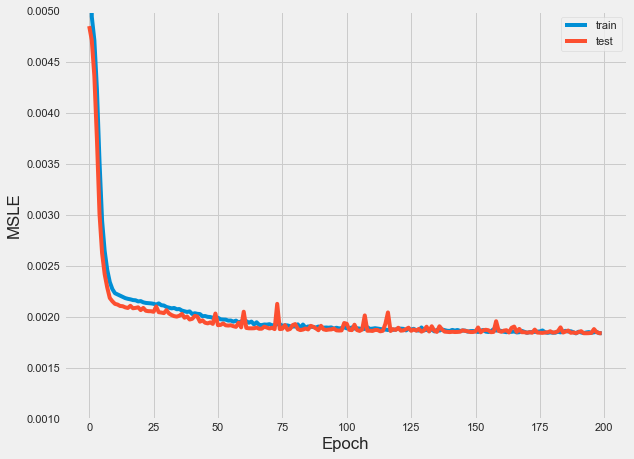

In [57]:
plt.figure(figsize=(9,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSLE')
plt.ylim([.001,.005])

(0.001, 0.008)

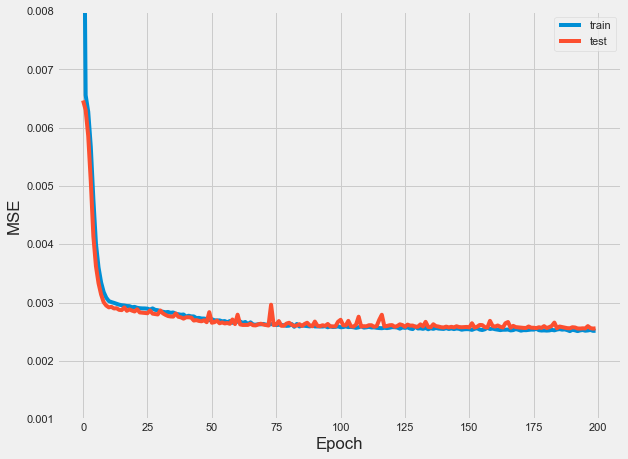

In [58]:
plt.figure(figsize=(9,7))
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([.001, .008])

## Use model to predict contracts for 2018-19 Season

In [151]:
features_2018_df = df_2018[features].drop('percent_of_cap', axis = 1).values
features_2018_df = scaler.transform(features_2018_df)
dnn_2018_predict = best_estimator.predict(features_2018_df)

In [164]:
shape = len(df_2018)
pred_vals = pd.DataFrame(dnn_2018_predict.reshape((shape,)), columns = ['dnn'] )
df_salary_pred = df_2018.join(pred_vals)
df_salary_pred['diff'] = df_salary_pred['dnn'] - df_salary_pred['percent_of_cap']

Text(0.5, 1.0, 'Observed vs Predicted Salary')

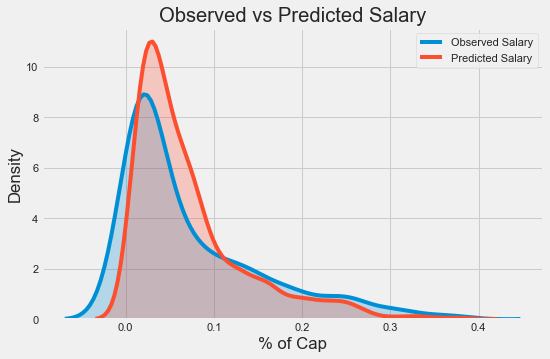

In [153]:
plt.figure(figsize=(8,5))
sns.kdeplot(df_salary_pred['percent_of_cap'], shade = True)
sns.kdeplot(df_salary_pred['dnn'], shade = True, )
plt.legend(['Observed Salary', 'Predicted Salary'])
plt.xlabel('% of Cap')
plt.ylabel('Density')
plt.title('Observed vs Predicted Salary')

### Determine Best and Worse Value Contracts for the 2018-19 Season

In [147]:
# function to make bar graph from predictions

def make_plot(df_rows, color, title, neg_bool, height, file_name):
    
    fig,ax = plt.subplots(figsize=(12,7))
    
    y = df_rows['diff']
    labels = df_rows['player']
    x = range(len(y))
    
    ax.bar(x, y, width = .7,  color = color, linewidth = 4, label = 'Predicted')
    
    rects = ax.patches
    
    if neg_bool == True:
        for rect, label in zip(rects, labels):
            ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
            ha='center', va='bottom', rotation = 'vertical', color = 'black',  fontsize = 20)
    else:
        for rect, label in zip(rects, labels):
            ax.text(rect.get_x() + rect.get_width() / 2.5, -height, label,
            ha='center', va='top', rotation = -90, color = 'black', fontsize = 20)

    fig.suptitle("%s" % title, weight = 'bold', size = 20)
    ax.xaxis.set_visible(False)
    tic_vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in tic_vals], fontsize = 13)
    ax.set_ylabel("Predicted - Observed % of Cap", fontsize = 16)


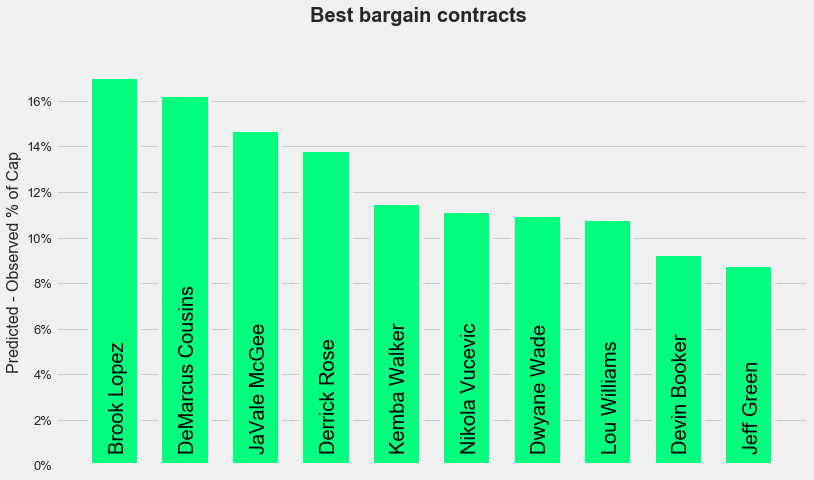

In [154]:

best_val = df_salary_pred.sort_values(by = 'diff', ascending = False).reset_index(drop = True).iloc[0:10]

make_plot(best_val, 'springgreen', "Best bargain contracts", True, 0.005, 'best-val')

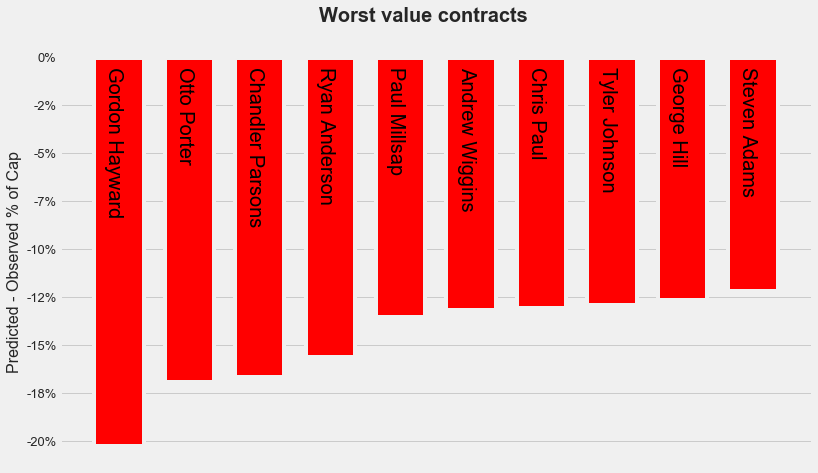

In [155]:
#Worst Value contracts

worst_val = df_salary_pred.sort_values(by = 'diff', ascending = True).reset_index(drop = True).iloc[0:10]

make_plot(worst_val, 'red', "Worst value contracts", False, 0.005, 'worst-val')

## Check the effect of years pro on salary (Luka Doncic)

In [182]:
luka = df_salary_pred[df_salary_pred['player'] == 'Luka Doncic'][features].drop('percent_of_cap', axis = 1).values

In [183]:
luka_sal=[]
for i in range (1,25):
    luka[0][0] = i
    luka = scaler.transform(luka)
    luka_sal.append(best_estimator.predict(luka))
    

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ]),
 <a list of 10 Text yticklabel objects>)

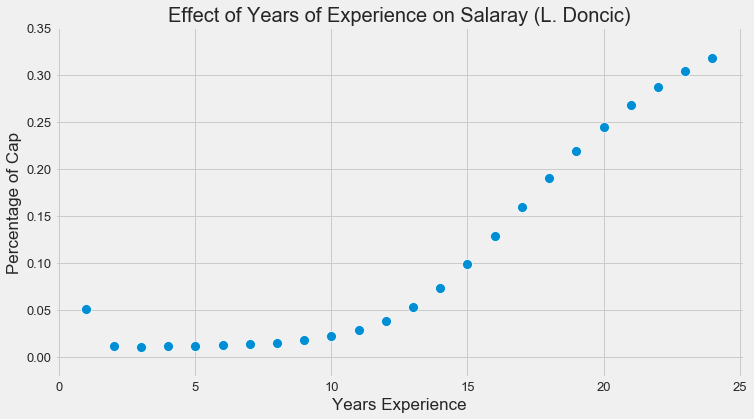

In [184]:
#Distribution of Salary
plt.figure(figsize=(11,6))
sns.scatterplot(x = [i for i in range(1,25)], y = luka_sal, s = 100)
plt.title('Effect of Years of Experience on Salaray (L. Doncic)', fontsize = 20)
plt.ylabel('Percentage of Cap', fontsize = 17)
plt.xlabel('Years Experience', fontsize = 17)

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

In [186]:
#Save models
import joblib
joblib.dump(best_estimator, 'DnnCV_model_nba_contract.sav')

TypeError: can't pickle _thread.RLock objects

In [163]:
dnn_2018_predict.reshape((459,)).shape

(459,)